In [1]:
# Colab: make sure to use GPU runtime if available
!pip -q install onnx onnxruntime-gpu onnxruntime timm --upgrade

import os, pathlib, torch
from pathlib import Path
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
!nvidia-smi -L || true

# Point to your dataset_split root (contains images/ and labels/)
DATASET_ROOT = Path("/content/dataset_split")  # <-- change if needed
assert (DATASET_ROOT/"images/train").exists() and (DATASET_ROOT/"labels/train").exists(), "dataset_split not found"

# Project output
PROJ = Path("/content/sign_proj"); PROJ.mkdir(parents=True, exist_ok=True)
( PROJ/"results/figs" ).mkdir(parents=True, exist_ok=True)

NAMES = ['yes','no','hello','iloveyou','thankyou']
NAME2IDX = {n:i for i,n in enumerate(NAMES)}
NC = len(NAMES)
print("Classes:", NAMES)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00
Torch: 2.8.0+cpu | CUDA: False
/bin/bash: line 1: nvidia-smi: command not found
Classes: ['yes', 'no', 'hello', 'iloveyou', 'thankyou']


In [2]:
import shutil, glob

SRC_IMG = DATASET_ROOT/"images"
SRC_LBL = DATASET_ROOT/"labels"
OUT_IMG = PROJ/"data"  # will hold ImageFolder structure
for split in ["train","val","test"]:
    (OUT_IMG/split).mkdir(parents=True, exist_ok=True)
    for cname in NAMES:
        (OUT_IMG/split/cname).mkdir(parents=True, exist_ok=True)

def parse_label_file(lbl_path: Path):
    """
    Returns class index (int) by reading the label file.
    Accepts:
      - '3'           -> int id
      - 'hello'       -> class name
      - '3 0.5 0.5...' (YOLO line) -> first token as int id
    """
    try:
        txt = lbl_path.read_text().strip()
    except Exception:
        return None
    if not txt:
        return None
    line = txt.splitlines()[0].strip()
    token = line.split()[0]
    # Try integer id
    if token.isdigit():
        idx = int(token)
        return idx if 0 <= idx < NC else None
    # Try name
    token_lower = token.lower()
    if token_lower in NAME2IDX:
        return NAME2IDX[token_lower]
    return None

def convert_split(split):
    img_dir = SRC_IMG/split
    lbl_dir = SRC_LBL/split
    out_dir = OUT_IMG/split
    images = sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])
    moved, skipped = 0, 0
    for img_path in images:
        base = img_path.stem
        lbl_candidates = list(lbl_dir.glob(base+"*"))
        if not lbl_candidates:
            # try matching by extension change
            lbl_candidates = [lbl_dir/(base+".txt")]
        if not lbl_candidates or not lbl_candidates[0].exists():
            skipped += 1
            continue
        idx = parse_label_file(lbl_candidates[0])
        if idx is None or idx >= NC:
            skipped += 1
            continue
        cname = NAMES[idx]
        dst = out_dir/cname/img_path.name
        shutil.copy2(img_path, dst)
        moved += 1
    print(f"[{split}] moved={moved}, skipped(no/malformed label)={skipped}")

for sp in ["train","val","test"]:
    convert_split(sp)

# quick counts
def count_images(root: Path):
    return sum(1 for p in root.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"})
print("Counts:",
      "train=", count_images(OUT_IMG/"train"),
      "val=",   count_images(OUT_IMG/"val"),
      "test=",  count_images(OUT_IMG/"test"))

[train] moved=87, skipped(no/malformed label)=0
[val] moved=25, skipped(no/malformed label)=0
[test] moved=13, skipped(no/malformed label)=0
Counts: train= 87 val= 25 test= 13


In [3]:
import random, math, numpy as np
from io import BytesIO
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
from tqdm import tqdm

ALLOW_HFLIP = False  # set True only if safe
TARGET_TOTAL = 500   # guarantee at least this many training images

TRAIN_SRC = OUT_IMG/"train"
VAL_SRC   = OUT_IMG/"val"
TEST_SRC  = OUT_IMG/"test"

def list_images(d):
    return [p for p in d.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]

def count_images(d): return len(list_images(d))

def rnd_resize_crop(img, out=224, scale=(0.85,1.15)):
    w,h=img.size; s=random.uniform(*scale)
    nw,nh=max(8,int(w*s)),max(8,int(h*s))
    img=img.resize((nw,nh), Image.BICUBIC)
    if nw>=out and nh>=out:
        x=random.randint(0,nw-out); y=random.randint(0,nh-out)
        return img.crop((x,y,x+out,y+out))
    return ImageOps.pad(img, (out,out), method=Image.BICUBIC, centering=(0.5,0.5))

def rnd_rotate_small(img, max_deg=12):
    return img.rotate(random.uniform(-max_deg,max_deg), resample=Image.BICUBIC, expand=False)

def rnd_affine(img, max_translate=0.08, max_shear=6):
    w,h=img.size; tx=random.uniform(-max_translate,max_translate)*w; ty=random.uniform(-max_translate,max_translate)*h
    shear=math.tan(math.radians(random.uniform(-max_shear,max_shear)))
    return img.transform(img.size, Image.AFFINE, (1,shear,tx, 0,1,ty), resample=Image.BICUBIC)

def rnd_color_jitter(img, b=0.12,c=0.12,s=0.12):
    if random.random()<0.7: img=ImageEnhance.Brightness(img).enhance(1+random.uniform(-b,b))
    if random.random()<0.7: img=ImageEnhance.Contrast(img).enhance(1+random.uniform(-c,c))
    if random.random()<0.6: img=ImageEnhance.Color(img).enhance(1+random.uniform(-s,s))
    return img

def rnd_blur_or_sharpen(img):
    r=random.random()
    if r<0.2:  img=img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3,1.0)))
    elif r<0.3: img=img.filter(ImageFilter.UnsharpMask(radius=2, percent=120, threshold=3))
    return img

def rnd_noise(img, sigma=4.0):
    if random.random()<0.25:
        arr=np.array(img).astype(np.float32)
        arr=np.clip(arr+np.random.normal(0,sigma,arr.shape).astype(np.float32),0,255).astype(np.uint8)
        img=Image.fromarray(arr)
    return img

def cutout(img, num_holes=1, max_frac=0.2):
    if random.random()<0.35:
        w,h=img.size; arr=np.array(img)
        for _ in range(num_holes):
            fh=int(h*random.uniform(0.06,max_frac))
            fw=int(w*random.uniform(0.06,max_frac))
            y=random.randint(0,max(0,h-fh)); x=random.randint(0,max(0,w-fw))
            arr[y:y+fh, x:x+fw,:] = np.mean(arr,axis=(0,1)).astype(arr.dtype)
        img=Image.fromarray(arr)
    return img

def maybe_hflip(img, p=0.0):
    return ImageOps.mirror(img) if random.random()<p else img

def augment_once(im):
    im=im.convert("RGB")
    im=rnd_resize_crop(im,224,(0.85,1.15))
    im=rnd_rotate_small(im,12)
    im=rnd_affine(im,0.08,6)
    im=maybe_hflip(im, 0.3 if ALLOW_HFLIP else 0.0)
    im=rnd_color_jitter(im)
    im=rnd_blur_or_sharpen(im)
    im=rnd_noise(im,4.0)
    im=cutout(im,1,0.2)
    return im

def img_bytes(im, q=92):
    b=BytesIO(); im.save(b, format="JPEG", quality=q, optimize=True); return b.getvalue()

train_total = count_images(TRAIN_SRC)
print("Original train total:", train_total)

if train_total >= TARGET_TOTAL:
    print("Already ≥ target; will use original train.")
    TRAIN_USE = TRAIN_SRC
else:
    print("Augmenting to reach ≥ target …")
    TRAIN_AUG = PROJ/"data_aug/train"
    if TRAIN_AUG.exists(): shutil.rmtree(TRAIN_AUG)
    TRAIN_AUG.mkdir(parents=True, exist_ok=True)
    # Copy originals into class dirs first
    for cls_dir in sorted(TRAIN_SRC.iterdir()):
        if cls_dir.is_dir():
            (TRAIN_AUG/cls_dir.name).mkdir(parents=True, exist_ok=True)
            for p in list_images(cls_dir):
                shutil.copy2(p, TRAIN_AUG/cls_dir.name/p.name)
    # Top up per class evenly
    cls_names = [d.name for d in sorted(TRAIN_SRC.iterdir()) if d.is_dir()]
    need = TARGET_TOTAL - count_images(TRAIN_AUG)
    per_cls_add = math.ceil(max(0,need)/max(1,len(cls_names)))
    for cname in cls_names:
        srcs = list_images(TRAIN_SRC/cname)
        outc = TRAIN_AUG/cname
        idx=0
        with tqdm(total=per_cls_add, desc=f"Aug {cname:>10}") as bar:
            while idx < per_cls_add and srcs:
                p = srcs[idx % len(srcs)]
                with Image.open(p) as im:
                    aug = augment_once(im)
                (outc/f"aug_{idx:05d}.jpg").write_bytes(img_bytes(aug,92))
                idx += 1; bar.update(1)
    print("New train total:", count_images(TRAIN_AUG))
    TRAIN_USE = TRAIN_AUG

VAL_USE = VAL_SRC
TEST_USE = TEST_SRC
print("Train dir:", TRAIN_USE)
print("Val dir:", VAL_USE)
print("Test dir:", TEST_USE)

Original train total: 87
Augmenting to reach ≥ target …


Aug        yes: 100%|██████████| 83/83 [00:06<00:00, 12.67it/s]

New train total: 502
Train dir: /content/sign_proj/data_aug/train
Val dir: /content/sign_proj/data/val
Test dir: /content/sign_proj/data/test


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 253MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] epoch 1 val_acc=0.3200
[resnet18] epoch 2 val_acc=0.4800
[resnet18] epoch 3 val_acc=0.5600
[resnet18] epoch 4 val_acc=0.6800
[resnet18] epoch 5 val_acc=0.8400
[resnet18] epoch 6 val_acc=0.7200
[resnet18] epoch 7 val_acc=0.8000
[resnet18] epoch 8 val_acc=0.8400
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 176MB/s]


[efficientnet_b0] epoch 1 val_acc=0.7600
[efficientnet_b0] epoch 2 val_acc=0.9200
[efficientnet_b0] epoch 3 val_acc=0.9200
[efficientnet_b0] epoch 4 val_acc=0.9600
[efficientnet_b0] epoch 5 val_acc=0.9600
[efficientnet_b0] epoch 6 val_acc=0.9200
[efficientnet_b0] epoch 7 val_acc=0.9600
[efficientnet_b0] epoch 8 val_acc=0.9600
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 344MB/s]


[vit_b_16] epoch 1 val_acc=0.5600
[vit_b_16] epoch 2 val_acc=0.7600
[vit_b_16] epoch 3 val_acc=0.8400
[vit_b_16] epoch 4 val_acc=0.8800
[vit_b_16] epoch 5 val_acc=0.8000
[vit_b_16] epoch 6 val_acc=0.8000
[vit_b_16] epoch 7 val_acc=0.9200
[vit_b_16] epoch 8 val_acc=0.9200


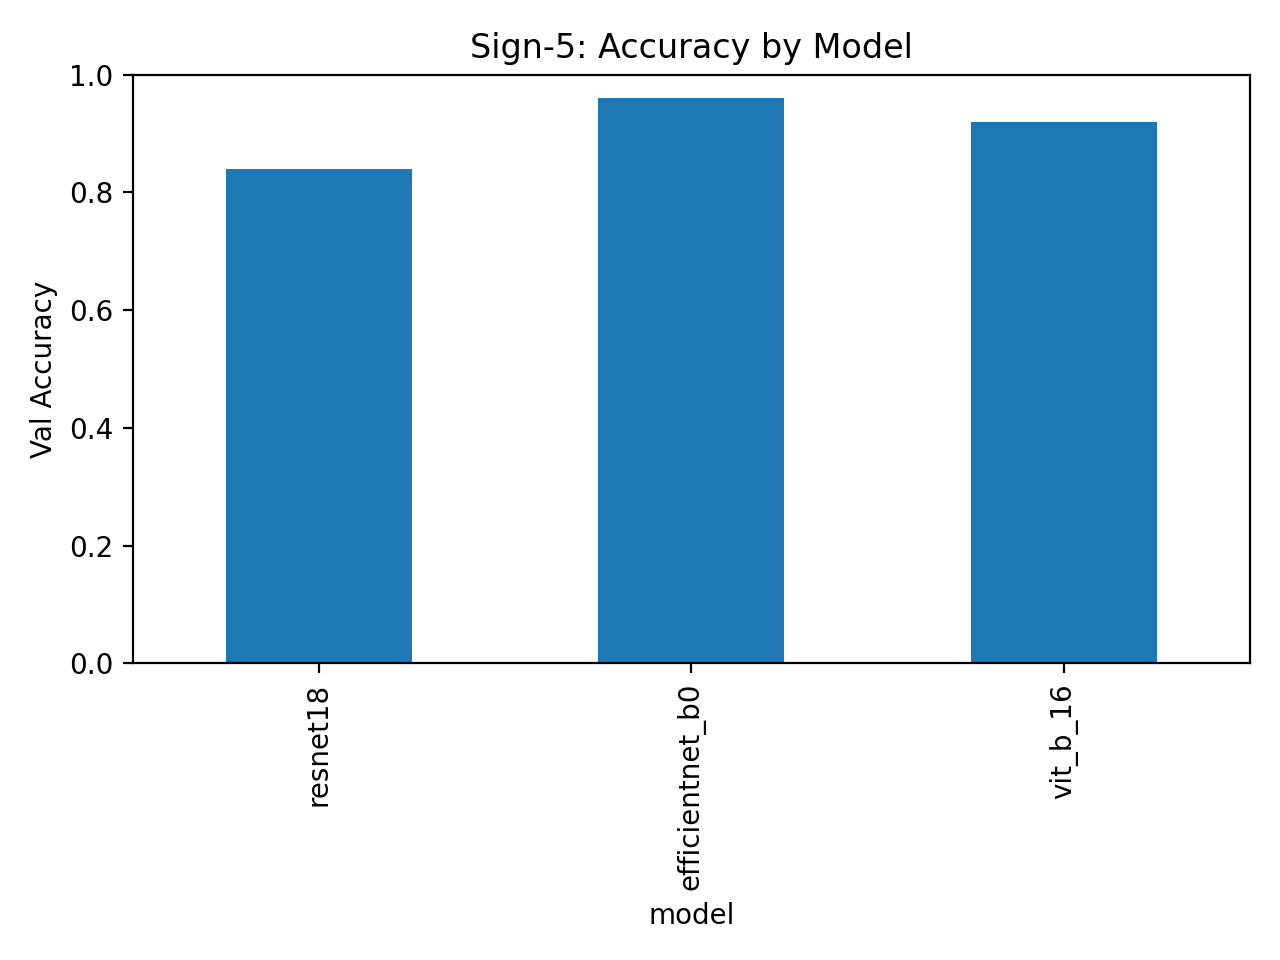

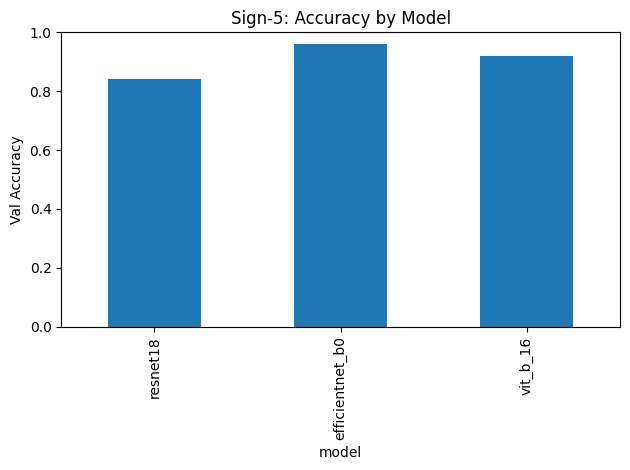

In [4]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def build(model_name, num_classes=NC, device=DEVICE):
    if model_name=="resnet18":
        m=models.resnet18(weights=models.ResNet18_Weights.DEFAULT); m.fc=nn.Linear(m.fc.in_features,num_classes)
        w=models.ResNet18_Weights.DEFAULT
    elif model_name=="efficientnet_b0":
        m=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT); m.classifier[-1]=nn.Linear(m.classifier[-1].in_features,num_classes)
        w=models.EfficientNet_B0_Weights.DEFAULT
    elif model_name=="vit_b_16":
        m=models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT); m.heads.head=nn.Linear(m.heads.head.in_features,num_classes)
        w=models.ViT_B_16_Weights.DEFAULT
    else: raise ValueError("resnet18/efficientnet_b0/vit_b_16")
    return m.to(device), w

def loaders(train_root, val_root, weights, bs=32, workers=2):
    tfm = weights.transforms()
    tr_ds = datasets.ImageFolder(str(train_root), transform=tfm)
    va_ds = datasets.ImageFolder(str(val_root),   transform=tfm)
    return (DataLoader(tr_ds, bs, True,  num_workers=workers, pin_memory=True),
            DataLoader(va_ds, bs, False, num_workers=workers, pin_memory=True))

@torch.no_grad()
def eval_acc(model, dl):
    model.eval(); right=tot=0
    for x,y in dl:
        x,y=x.to(DEVICE), y.to(DEVICE)
        pred=model(x).argmax(1)
        right+=(pred==y).sum().item(); tot+=y.numel()
    return right/tot

from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt
OUT = PROJ/"results"; OUT.mkdir(parents=True, exist_ok=True)

def train_one(name, epochs=8, bs=32, lr=1e-3):
    m,w = build(name, NC, DEVICE)
    tr,va = loaders(TRAIN_USE, VAL_USE, w, bs=bs)
    # freeze backbone speeds training
    for n,p in m.named_parameters():
        if not any(k in n for k in ["fc","classifier","heads"]): p.requires_grad=False
    opt = torch.optim.AdamW(filter(lambda p:p.requires_grad, m.parameters()), lr=lr, weight_decay=1e-4)
    loss = nn.CrossEntropyLoss()
    best=0.0
    for ep in range(1,epochs+1):
        m.train()
        for x,y in tr:
            x,y=x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(); l=loss(m(x),y); l.backward(); opt.step()
        acc=eval_acc(m,va)
        print(f"[{name}] epoch {ep} val_acc={acc:.4f}")
        torch.save(m.state_dict(), OUT/f"{name}_last.pth")
        if acc>best:
            best=acc; torch.save(m.state_dict(), OUT/f"{name}_best.pth")
    return best

metrics=[]
for name in ["resnet18","efficientnet_b0","vit_b_16"]:
    metrics.append({"model": name, "val_acc": train_one(name, epochs=8, bs=32)})

pd.DataFrame(metrics).to_csv(OUT/"metrics.csv", index=False)
# Figure
df = pd.DataFrame(metrics)
ax = df.plot(x="model", y="val_acc", kind="bar", legend=False)
ax.set_ylim(0,1); ax.set_ylabel("Val Accuracy"); ax.set_title("Sign-5: Accuracy by Model")
ax.figure.tight_layout(); ax.figure.savefig(OUT/"figs/acc_by_model.png", dpi=200)
from IPython.display import Image, display; display(Image(filename=str(OUT/"figs/acc_by_model.png")))


In [5]:
def test_accuracy(name):
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pth", map_location=DEVICE)); m.eval()
    _, w = build(name, NC, DEVICE)
    test_ds = datasets.ImageFolder(str(TEST_USE), transform=w.transforms())
    test_dl = DataLoader(test_ds, 32, False)
    return eval_acc(m, test_dl)

for name in ["resnet18","efficientnet_b0","vit_b_16"]:
    print(name, "test_acc:", f"{test_accuracy(name):.4f}")


resnet18 test_acc: 0.9231
efficientnet_b0 test_acc: 1.0000
vit_b_16 test_acc: 0.9231


In [6]:
import torch, time, numpy as np, pandas as pd, onnxruntime as ort

def export_ts(name):
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pth", map_location=DEVICE)); m.eval()
    ts = torch.jit.trace(m, torch.randn(1,3,224,224, device=DEVICE))
    torch.jit.save(ts, OUT/f"{name}_ts.pt"); print("Saved TS:", OUT/f"{name}_ts.pt")

def export_onnx(name):
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pth", map_location=DEVICE)); m.eval()
    dummy = torch.randn(1,3,224,224, device=DEVICE)
    torch.onnx.export(m, dummy, OUT/f"{name}.onnx",
                      input_names=["input"], output_names=["logits"],
                      dynamic_axes={"input":{0:"batch"}, "logits":{0:"batch"}},
                      opset_version=17)
    print("Saved ONNX:", OUT/f"{name}.onnx")

for n in ["resnet18","efficientnet_b0"]:
    export_ts(n); export_onnx(n)

def tavg(fn, iters=50, warmup=10):
    for _ in range(warmup): fn()
    t0=time.time()
    for _ in range(iters): fn()
    return (time.time()-t0)*1000/iters

def bench_pytorch(model, bs):
    x = torch.randn(bs,3,224,224, device=DEVICE)
    @torch.inference_mode()
    def step(): _ = model(x).argmax(1)
    return tavg(step)

def bench_ts(ts_path, bs):
    m = torch.jit.load(ts_path, map_location=DEVICE).eval()
    x = torch.randn(bs,3,224,224, device=DEVICE)
    @torch.inference_mode()
    def step(): _ = m(x).argmax(1)
    return tavg(step)

def bench_onnx(onnx_path, bs):
    providers = ["CUDAExecutionProvider","CPUExecutionProvider"] if torch.cuda.is_available() else ["CPUExecutionProvider"]
    sess = ort.InferenceSession(str(onnx_path), providers=providers)
    x = np.random.randn(bs,3,224,224).astype(np.float32)
    def step(): _ = sess.run(["logits"], {"input": x})
    return tavg(step)

rows=[]
for name in ["resnet18","efficientnet_b0"]:
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pth", map_location=DEVICE)); m.eval()
    for bs in [1,32]:
        rows.append(dict(model=name, impl="pytorch",    bs=bs, ms=bench_pytorch(m, bs)))
        rows.append(dict(model=name, impl="torchscript", bs=bs, ms=bench_ts(OUT/f"{name}_ts.pt", bs)))
        rows.append(dict(model=name, impl="onnxruntime", bs=bs, ms=bench_onnx(OUT/f"{name}.onnx", bs)))

bench = pd.DataFrame(rows); bench["img_s"] = (1000/bench["ms"])*bench["bs"]
bench.to_csv(OUT/"bench.csv", index=False); bench


Saved TS: /content/sign_proj/results/resnet18_ts.pt


/tmp/ipython-input-1096079364.py:13: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(m, dummy, OUT/f"{name}.onnx",


Saved ONNX: /content/sign_proj/results/resnet18.onnx
Saved TS: /content/sign_proj/results/efficientnet_b0_ts.pt
Saved ONNX: /content/sign_proj/results/efficientnet_b0.onnx


,model,impl,bs,ms,img_s
0,resnet18,pytorch,1,38.297257,26.111530
1,resnet18,torchscript,1,34.216180,29.225939
2,resnet18,onnxruntime,1,16.202374,61.719352
3,resnet18,pytorch,32,578.414960,55.323604
4,resnet18,torchscript,32,604.145041,52.967413
5,resnet18,onnxruntime,32,367.599144,87.051345
6,efficientnet_b0,pytorch,1,56.273932,17.770217
7,efficientnet_b0,torchscript,1,44.112749,22.669183
8,efficientnet_b0,onnxruntime,1,20.023069,49.942393
9,efficientnet_b0,pytorch,32,600.370188,53.300448


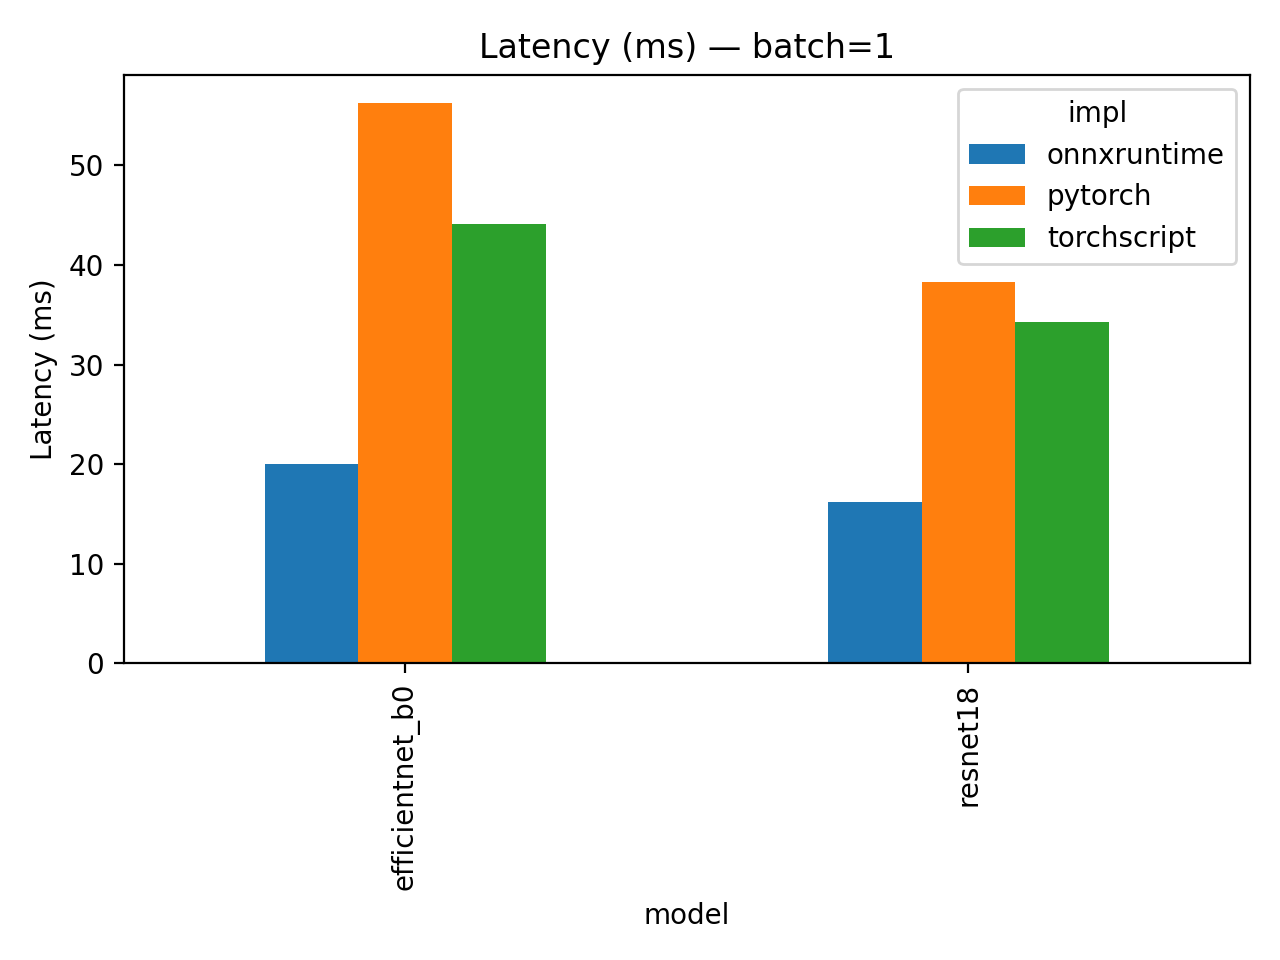

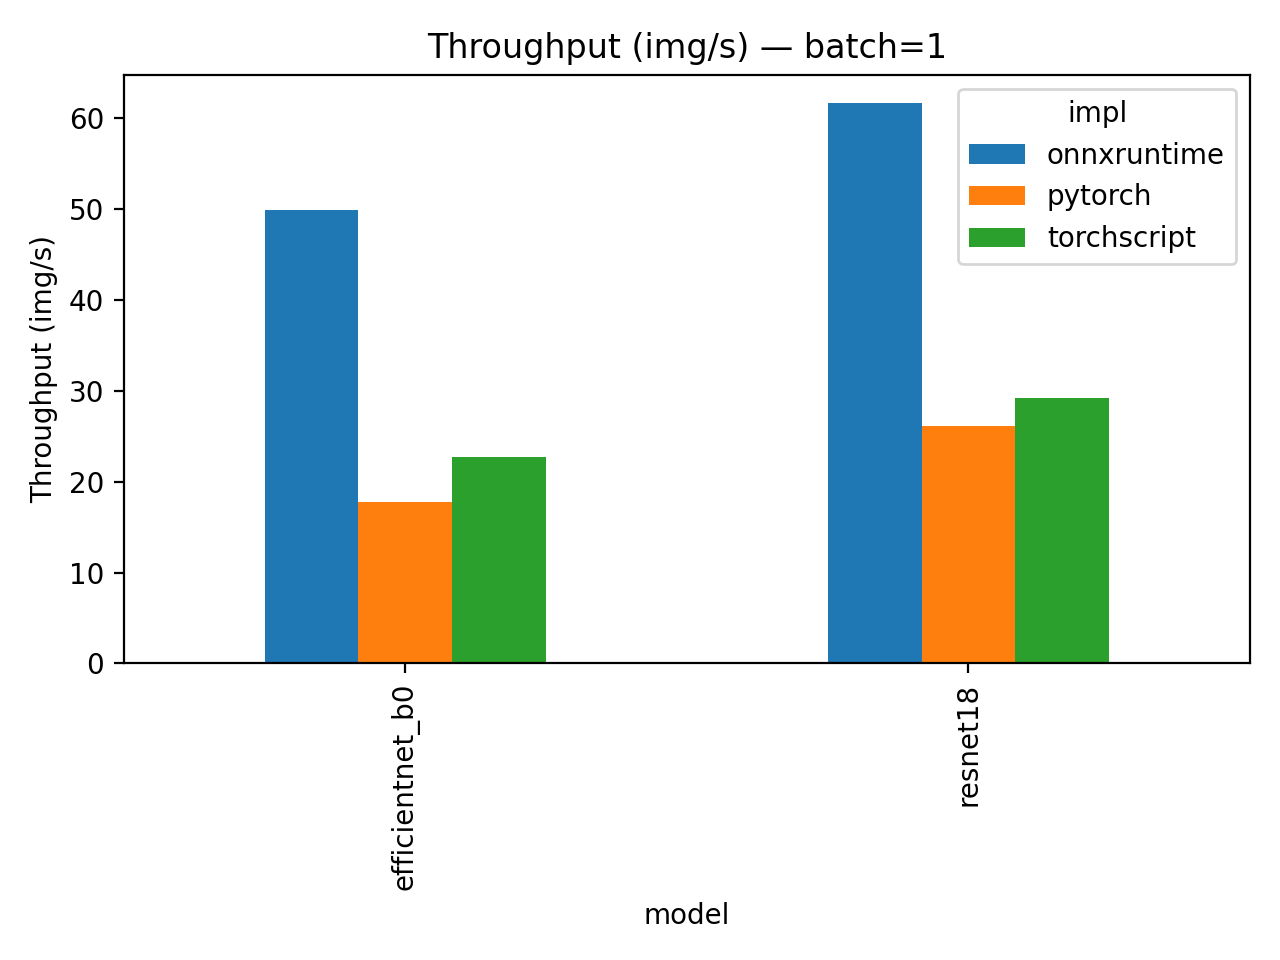

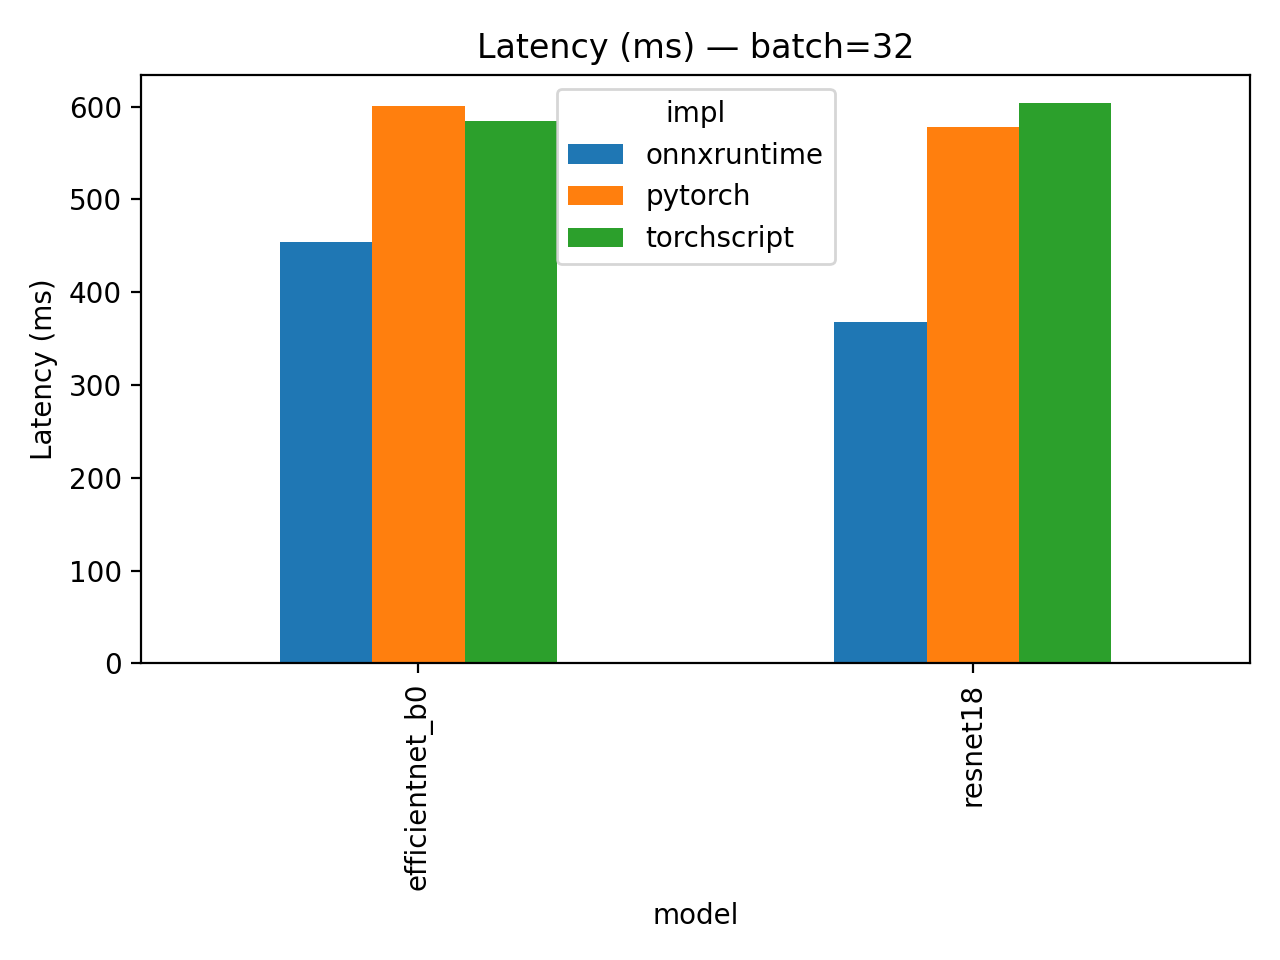

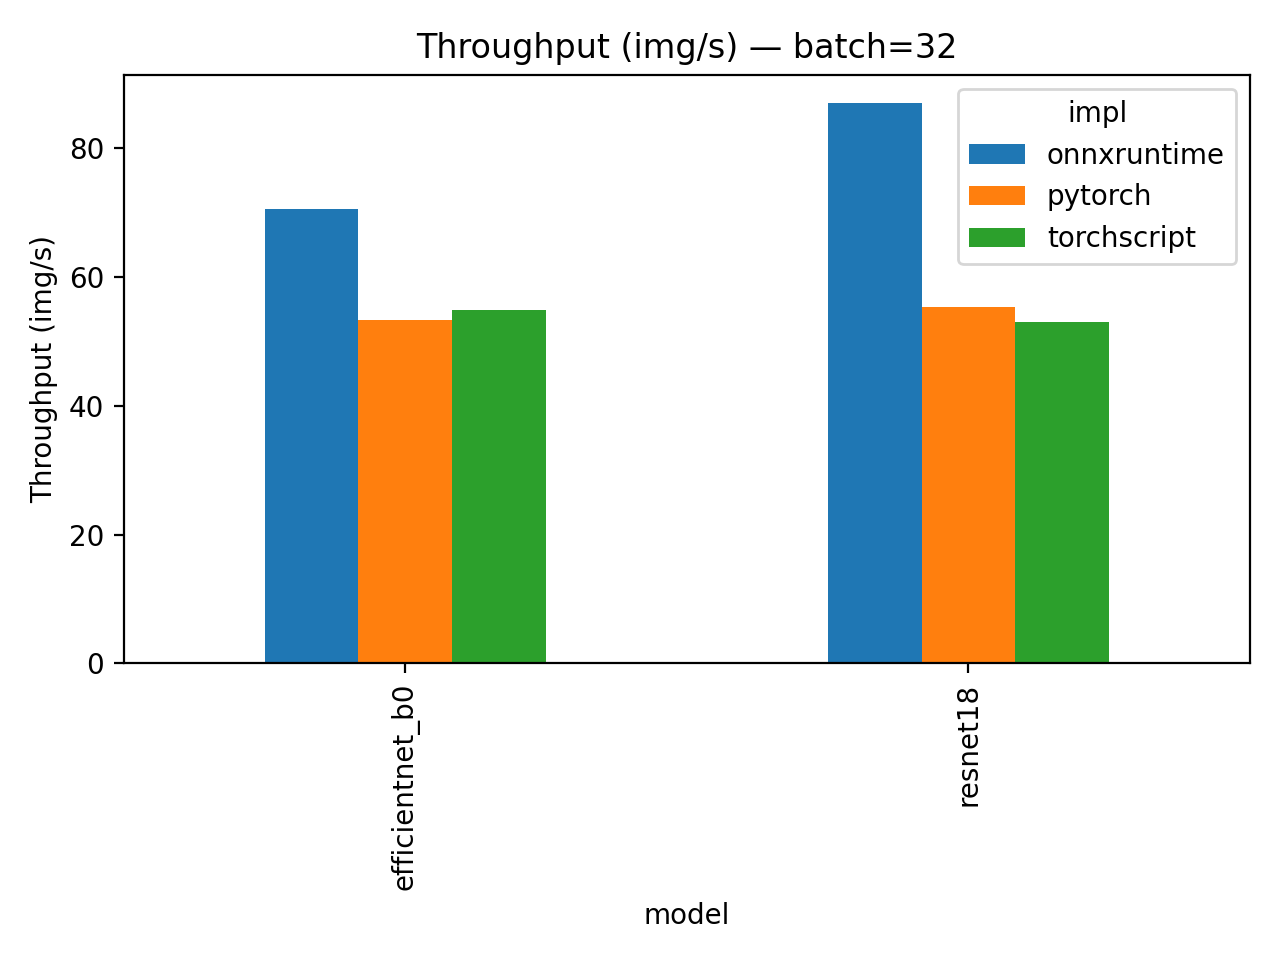

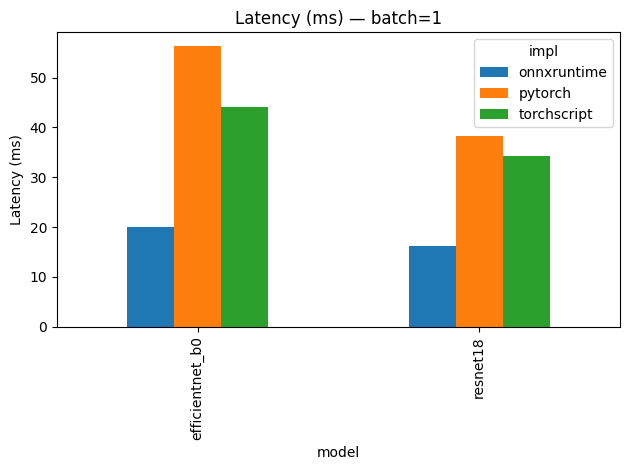

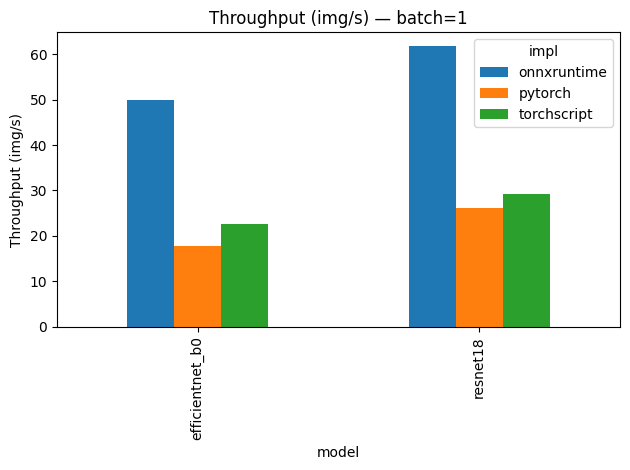

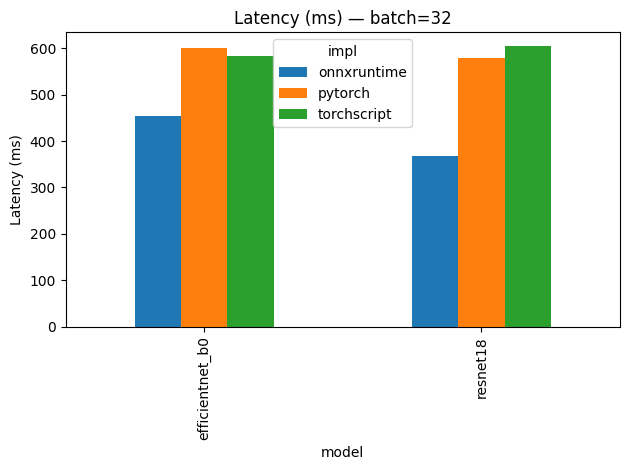

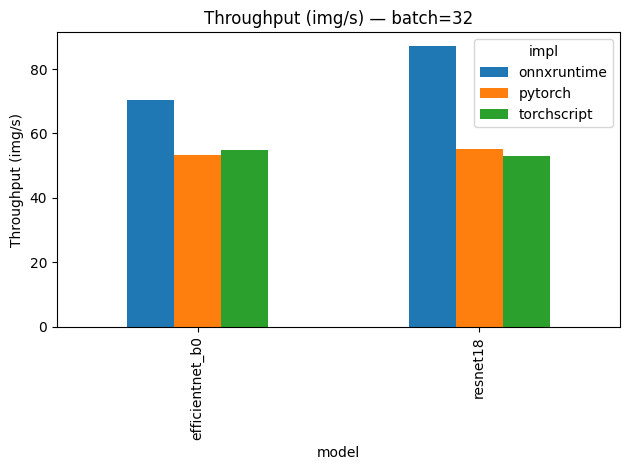

In [7]:
import pandas as pd, matplotlib.pyplot as plt
bench = pd.read_csv(OUT/"bench.csv")
for bs in [1,32]:
    sub = bench[bench.bs==bs]
    for col,title in [("ms","Latency (ms)"), ("img_s","Throughput (img/s)")]:
        ax = sub.pivot(index="model", columns="impl", values=col).plot(kind="bar")
        ax.set_ylabel(title); ax.set_title(f"{title} — batch={bs}")
        ax.figure.tight_layout(); ax.figure.savefig(OUT/f"figs/{col}_bs{bs}.png", dpi=200)

from IPython.display import Image, display
display(Image(filename=str(OUT/"figs/ms_bs1.png")))
display(Image(filename=str(OUT/"figs/img_s_bs1.png")))
display(Image(filename=str(OUT/"figs/ms_bs32.png")))
display(Image(filename=str(OUT/"figs/img_s_bs32.png")))


In [22]:
# Print the ONNX Runtime providers the session is using (document in your report)
import onnxruntime as ort, torch
from pathlib import Path
name = "resnet18"
onnx_path = PROJ/"results"/f"{name}.onnx"
sess = ort.InferenceSession(str(onnx_path), providers=["CUDAExecutionProvider","CPUExecutionProvider"])
print("Available providers:", ort.get_available_providers())
print("Session providers:", sess.get_providers())
print("Using GPU EP?" , "CUDAExecutionProvider" in sess.get_providers() and torch.cuda.is_available())


Available providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
Session providers: ['CPUExecutionProvider']
Using GPU EP? False


/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [9]:
# Reproducibility across Python/NumPy/Torch (CPU+CUDA)
import os, random, numpy as np, torch
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# (optional) strict determinism; may slow down a bit:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("Seeds set:", SEED, "| CUDA:", torch.cuda.is_available())


Seeds set: 1337 | CUDA: False


In [11]:
# Verify ImageFolder class-index order and counts per split
from torchvision import datasets
from pathlib import Path
import pandas as pd

# Try to pick existing dirs from previous cells
try:
    # Use the variables set in the data preparation and augmentation steps
    splits = {
        "train": Path(TRAIN_USE),
        "val":   Path(VAL_USE),
        "test":  Path(TEST_USE),
    }
except NameError:
    # Fallback if the variables are not defined
    DATA_BASE = Path("/content/sign_proj/data")
    splits = {
        "train": (DATA_BASE/"train"),
        "val":   (DATA_BASE/"val"),
        "test":  (DATA_BASE/"test"),
    }


def count_by_class(root: Path):
    rows=[]
    for cdir in sorted([d for d in root.iterdir() if d.is_dir()]):
        n = len([p for p in cdir.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])
        rows.append({"class": cdir.name, "count": n})
    return pd.DataFrame(rows)

# Show class_to_idx for train
train_ds = datasets.ImageFolder(str(splits["train"]))
print("ImageFolder class_to_idx:", train_ds.class_to_idx)
try:
    print("Declared names:", NAMES)
except NameError:
    NAMES = sorted(list(train_ds.class_to_idx.keys()))
    print("Declared names not found; using discovered:", NAMES)

for sp, path in splits.items():
    dfc = count_by_class(path)
    print(f"\n[{sp}] total={dfc['count'].sum()}")
    display(dfc)

ImageFolder class_to_idx: {'hello': 0, 'iloveyou': 1, 'no': 2, 'thankyou': 3, 'yes': 4}
Declared names: ['yes', 'no', 'hello', 'iloveyou', 'thankyou']

[train] total=502


,class,count
0,hello,101
1,iloveyou,99
2,no,103
3,thankyou,99
4,yes,100



[val] total=25


,class,count
0,hello,5
1,iloveyou,4
2,no,5
3,thankyou,6
4,yes,5



[test] total=13


,class,count
0,hello,2
1,iloveyou,5
2,no,1
3,thankyou,2
4,yes,3


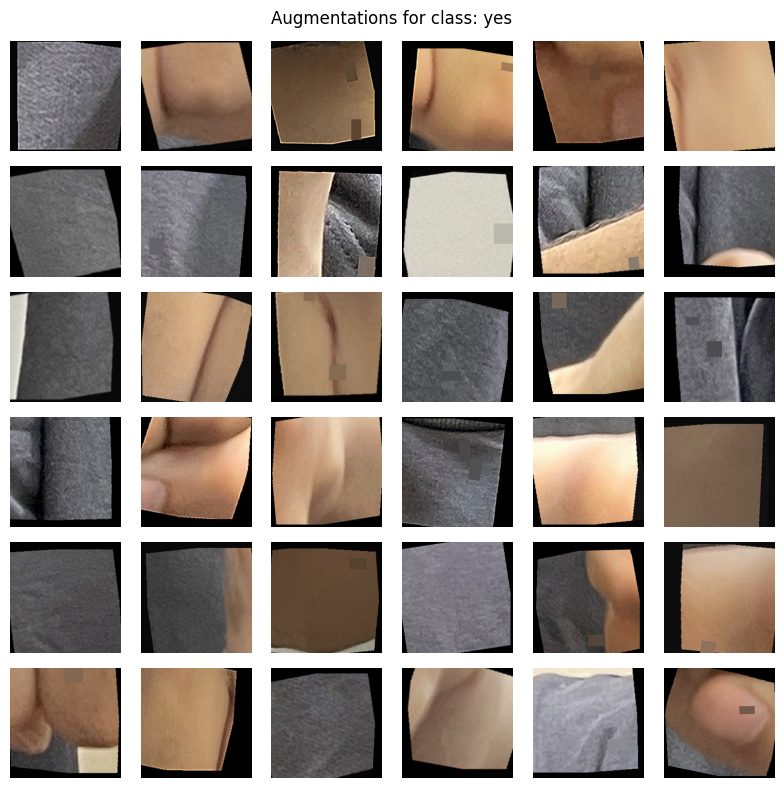

In [17]:
# Make a 6x6 grid of augmented samples from one class (uses same augment_once as before)
import random, matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Reuse augment_once from earlier; if not present, define a mild version quickly:
try:
    augment_once
except NameError:
    import numpy as np
    from PIL import ImageOps, ImageFilter, ImageEnhance
    def augment_once(im):
        import math
        import random
        def rnd_resize_crop(img, out=224, scale=(0.85,1.15)):
            w,h=img.size; s=random.uniform(*scale)
            nw,nh=max(8,int(w*s)),max(8,int(h*s))
            img=img.resize((nw,nh), Image.BICUBIC)
            if nw>=out and nh>=out:
                x=random.randint(0,nw-out); y=random.randint(0,nh-out)
                return img.crop((x,y,x+out,y+out))
            return ImageOps.pad(img, (out,out), method=Image.BICUBIC, centering=(0.5,0.5))
        def rnd_rotate_small(img, max_deg=12):
            return img.rotate(random.uniform(-max_deg,max_deg), resample=Image.BICUBIC, expand=False)
        def rnd_affine(img, max_translate=0.08, max_shear=6):
            w,h=img.size; tx=random.uniform(-max_translate,max_translate)*w; ty=random.uniform(-max_translate,max_translate)*h
            shear=math.tan(math.radians(random.uniform(-max_shear,max_shear)))
            return img.transform(img.size, Image.AFFINE, (1,shear,tx, 0,1,ty), resample=Image.BICUBIC)
        def rnd_color_jitter(img, b=0.12,c=0.12,s=0.12):
            if random.random()<0.7: img=ImageEnhance.Brightness(img).enhance(1+random.uniform(-b,b))
            if random.random()<0.7: img=ImageEnhance.Contrast(img).enhance(1+random.uniform(-c,c))
            if random.random()<0.6: img=ImageEnhance.Color(img).enhance(1+random.uniform(-s,s))
            return img
        def rnd_blur_or_sharpen(img):
            r=random.random()
            if r<0.2:  img=img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3,1.0)))
            elif r<0.3: img=img.filter(ImageFilter.UnsharpMask(radius=2, percent=120, threshold=3))
            return img
        def rnd_noise(img, sigma=4.0):
            if random.random()<0.25:
                arr=np.array(img).astype(np.float32)
                arr=np.clip(arr+np.random.normal(0,sigma,arr.shape).astype(np.float32),0,255).astype(np.uint8)
                img=Image.fromarray(arr)
            return img
        def cutout(img, num_holes=1, max_frac=0.2):
            if random.random()<0.35:
                w,h=img.size; arr=np.array(img)
                for _ in range(num_holes):
                    fh=int(h*random.uniform(0.06,max_frac))
                    fw=int(w*random.uniform(0.06,max_frac))
                    y=random.randint(0,max(0,h-fh)); x=random.randint(0,max(0,w-fw))
                    arr[y:y+fh, x:x+fw,:] = np.mean(arr,axis=(0,1)).astype(arr.dtype)
                img=Image.fromarray(arr)
            return img
        im=im.convert("RGB")
        im=rnd_resize_crop(im,224,(0.85,1.15))
        im=rnd_rotate_small(im,12)
        im=rnd_affine(im,0.08,6)
        im=rnd_color_jitter(im)
        im=rnd_blur_or_sharpen(im)
        im=rnd_noise(im,4.0)
        im=cutout(im,1,0.2)
        return im

sample_class = NAMES[0]  # pick one
train_dir = Path(str(DATA_BASE))/"train"/sample_class
images = [p for p in train_dir.glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
assert len(images)>0, "No images found to visualize."

k = min(36, len(images))
sel = random.sample(images, k)

fig, axes = plt.subplots(6,6, figsize=(8,8))
for ax, p in zip(axes.flat, sel):
    with Image.open(p) as im:
        ax.imshow(augment_once(im))
    ax.axis('off')
plt.suptitle(f"Augmentations for class: {sample_class}")
plt.tight_layout()
fig.savefig(PROJ/"results/figs/augment_grid.png", dpi=200)


              precision    recall  f1-score   support

         yes     1.0000    1.0000    1.0000         2
          no     1.0000    0.8000    0.8889         5
       hello     0.5000    1.0000    0.6667         1
    iloveyou     1.0000    1.0000    1.0000         2
    thankyou     1.0000    1.0000    1.0000         3

    accuracy                         0.9231        13
   macro avg     0.9000    0.9600    0.9111        13
weighted avg     0.9615    0.9231    0.9316        13



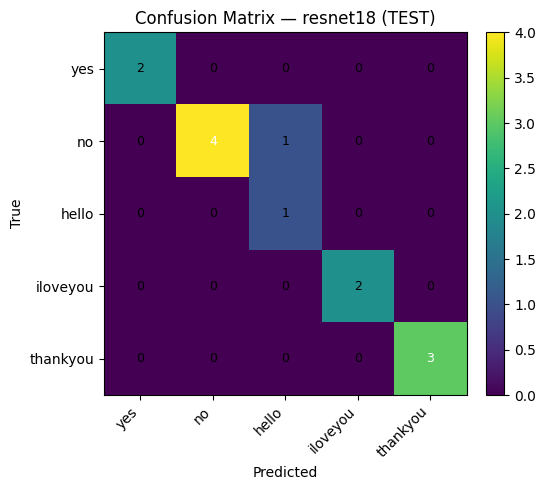

In [18]:
# Confusion matrix and classification report (macro-F1) on TEST
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
from torchvision import datasets

# pick the *best* of your 3 models for reporting, or do all 3
MODEL_FOR_REPORT = "resnet18"

m,_ = build(MODEL_FOR_REPORT, len(NAMES), DEVICE)
m.load_state_dict(torch.load(PROJ/"results"/f"{MODEL_FOR_REPORT}_best.pth", map_location=DEVICE)); m.eval()

# Use the model's weight transforms
_, w = build(MODEL_FOR_REPORT, len(NAMES), DEVICE)
test_ds = datasets.ImageFolder(str(TEST_USE), transform=w.transforms())
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

all_y, all_p = [], []
with torch.inference_mode():
    for x,y in test_dl:
        x = x.to(DEVICE)
        logits = m(x)
        pred = logits.argmax(1).cpu().numpy()
        all_p.append(pred); all_y.append(y.numpy())
y_true = np.concatenate(all_y); y_pred = np.concatenate(all_p)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(NAMES))))
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title(f"Confusion Matrix — {MODEL_FOR_REPORT} (TEST)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(NAMES))); ax.set_xticklabels(NAMES, rotation=45, ha='right')
ax.set_yticks(range(len(NAMES))); ax.set_yticklabels(NAMES)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=9, color="white" if cm[i,j] > cm.max()/2 else "black")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
fig.savefig(PROJ/"results/figs/confusion_matrix_test.png", dpi=200)

# Classification report
report = classification_report(y_true, y_pred, target_names=NAMES, digits=4, zero_division=0)
print(report)
with open(PROJ/"results/classification_report_test.txt","w") as f:
    f.write(report)

In [24]:
# Install if needed
!pip -q install open-clip-torch --upgrade

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import open_clip, time

# Check for CUDA availability and set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BACKBONE = "ViT-B-32"
PRETRAIN = "laion2b_s34b_b79k"
BATCH = 32
EPOCHS = 5
LR = 1e-3

# Data: use ImageFolder train/val we built
# Use the variables set in the data preparation and augmentation steps
try:
    train_dir = Path(TRAIN_USE)
    val_dir = Path(VAL_USE)
except NameError:
    # Fallback if the variables are not defined (shouldn't happen if previous cells ran)
    DATA_BASE = Path("/content/sign_proj/data")
    train_dir = DATA_BASE/"train"
    val_dir = DATA_BASE/"val"


model, _, preprocess = open_clip.create_model_and_transforms(BACKBONE, pretrained=PRETRAIN, device=DEVICE)
for p in model.parameters(): p.requires_grad=False  # freeze
feat_dim = model.visual.output_dim
head = nn.Linear(feat_dim, len(NAMES)).to(DEVICE)

train_ds = datasets.ImageFolder(str(train_dir), transform=preprocess)
val_ds   = datasets.ImageFolder(str(val_dir),   transform=preprocess)
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

opt = torch.optim.AdamW(head.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()

@torch.no_grad()
def acc(dl):
    right=tot=0
    for x,y in dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        feats = model.encode_image(x)
        logits = head(feats)
        right += (logits.argmax(1)==y).sum().item(); tot += y.numel()
    return right/tot

best=0.0
for ep in range(1, EPOCHS+1):
    head.train()
    for x,y in train_dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            feats = model.encode_image(x)
        loss = crit(head(feats), y)
        opt.zero_grad(); loss.backward(); opt.step()
    va = acc(val_dl)
    print(f"[CLIP linear] epoch {ep} val_acc={va:.4f}")
    if va>best:
        best=va; torch.save(head.state_dict(), PROJ/"results"/"clip_linear_best.pth")
print("Best CLIP-linear val_acc:", best)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[CLIP linear] epoch 1 val_acc=0.4800
[CLIP linear] epoch 2 val_acc=0.7200
[CLIP linear] epoch 3 val_acc=0.8400
[CLIP linear] epoch 4 val_acc=0.9200
[CLIP linear] epoch 5 val_acc=0.9200
Best CLIP-linear val_acc: 0.92
